# Andrej Karpathy's Zero to Hero: micrograd

This is an implementation of Andrej's video on [building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0).

In [40]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os

# Set Graphviz path if not already in PATH
graphviz_path = r'C:\Program Files\Graphviz\bin'  # Adjust to your installation
if os.path.exists(graphviz_path) and graphviz_path not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + graphviz_path
    print(f"Added Graphviz to PATH: {graphviz_path}")
else:
    print("Graphviz path already configured or not found")

%matplotlib inline

Graphviz path already configured or not found


## Example

`f` below is just a random function to demonstrate the basics of derivative. We are going to plot it using matplotlib and later, a few cells below, we'll calculate some derivative.

A derivative is a rate of change at a given point. Basically, for this function, we are going to calculate how much the result of `f(x)` change if we nudge `x` a little bit. "Nudging" here, look like this: `f(x+h)`.

In [41]:
# The Function
def f(x):
    return 3*x**2 - 4*x + 5

In [42]:
# A simple call and result of this function
f(3.0)

20.0

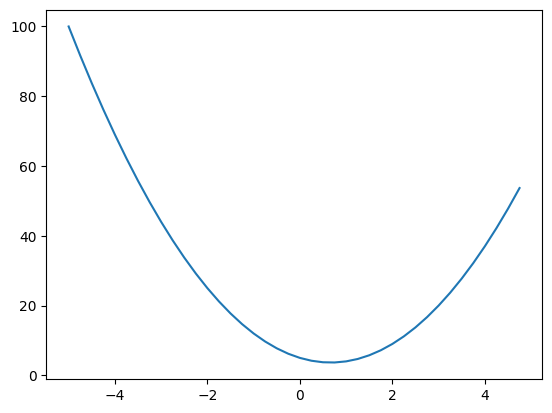

In [43]:
# We create a range of value, from -5 to 5 with a step of 0.25, to plot the function
xs = np.arange(-5.0, 5.0, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [44]:
# This is where the nudging happens.
h = 0.00001
x = 2 / 3

# Calculate the derivative of `x` using finite difference approximation
# It is important to understand that we are normalizing the result by the step size `h`. So the calculated derivative is per unit change of `x`.
(f(x + h) - f(x)) / h

3.0000002482211127e-05

In [45]:
# Let's try another example to build a better intuition about the derivative.
h = 0.000001

a = 2.0
b = -3.0
c = 10

d1 = a * b + c
# By nudging the different values of the function, we can observe how the derivative changes.
# Observations: by changing `a`, the derivative is `b`. By changing `b`, the derivative is `a`. And by changing `c`, the derivative is `1`. Why?
a += h
d2 = a * b + c

print('slope', (d2 - d1) / h)

slope -3.000000000419334


## Value Object

Below we create a value object that will help us create a graph, or neural network.

In [46]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        # _backward is a function that will be called when we backpropagate the gradient. The function is a lambda that will be defined depending on the operation.
        self._backward = lambda: None
        self._prev = _children
        self._op = _op

    def __repr__(self):
        return f'{self.__class__.__name__}({self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # We define the backward function for the addition operation by simply distributing the gradient of the output.
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + -1*other

    def __rsub__(self, other):
        return -1*self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # We define the backward function for the multiplication operation by taking the other term in the product and multiplying it by the gradient.
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int and float"
        out = Value(self.data ** other, (self,), '**')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')

        # We define the backward function for the tanh operation.
        def _backward():
            self.grad += (1 - math.tanh(self.data) ** 2) * out.grad

        out._backward = _backward

        return out

    """
    This is where the backpropagation happens.
    We'll first create a topological sort of the graph and call the _backward function for each node.
    """
    def backward(self):
        # Topological sort of the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        # The initial gradient is always 1.0
        self.grad = 1.0

        for n in reversed(topo):
            n._backward()



In [47]:
a = Value(2.0)
b = Value(5.0)
a - b

Value(-3.0)

## Graph Visualization

We use Graphviz for visualization. Below are functions that help with building the nodes and edges of the graph.

In [48]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad, ), shape = 'record')
        if n._op:
            # create an op node for each op
            dot.node(name = uid + n._op, label = n._op)
            # connect the op node to the data node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### Graph Creation

In [49]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'

L.backward()

L

Value(-8.0)

### Visualization

Looking at the visualization, we can clearly see the back propagation of the gradient. For example, `dL/da = 6.0`, which means that `L` changes by `6.0` when `a` changes by `1.0`. The back propagation is done by using the Chain Rule.

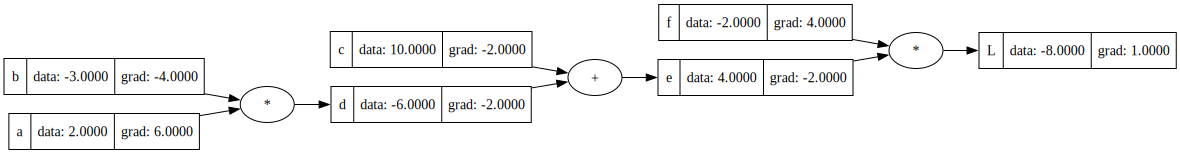

In [50]:
draw_dot(L)

In [51]:
def lol():
    h = 0.000001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label='f')
    L1 = e * f; L1.label = 'L'

    # For verification purpose, we nudge the value of `a` a little bit, the result should be 6.0.
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label='f')
    L2 = e * f; L2.label = 'L'

    d = (L2.data - L1.data) / h
    return d

lol()

6.000000000838668

## Example of a Neuron

Below we are going to apply a back propagation on a simple neuron. The formula for a neuron is: f(wx + b)

`f` here is an activation function, the activation is squashing the values. We will use `tanh` as our activation function. Other activation fonctions can be: ReLU, Sigmoid, Linear Identity, Swish, Softmax.

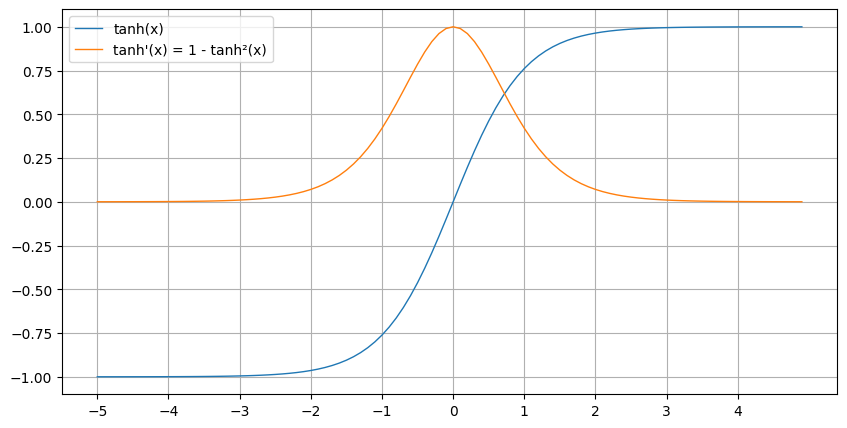

In [52]:
# Calculate the derivative of tanh
o = np.arange(-5.0, 5.0, 0.1)
b = np.tanh(o)

# Derivative of tanh(x) is 1 - tanh(x)^2
d = 1 - b ** 2

plt.figure(figsize=(10, 5))
plt.xticks(np.arange(-5, 5, 1))
plt.plot(o, b, label='tanh(x)', linewidth=1)
plt.plot(o, d, label="tanh'(x) = 1 - tanh²(x)", linewidth=1)
plt.legend()
plt.grid()
plt.show()


### Example of simple neuron

What we will really care about below is the back propagation of the derivatives of the weights because the weights are going to be changed specifically to influence the neural network.

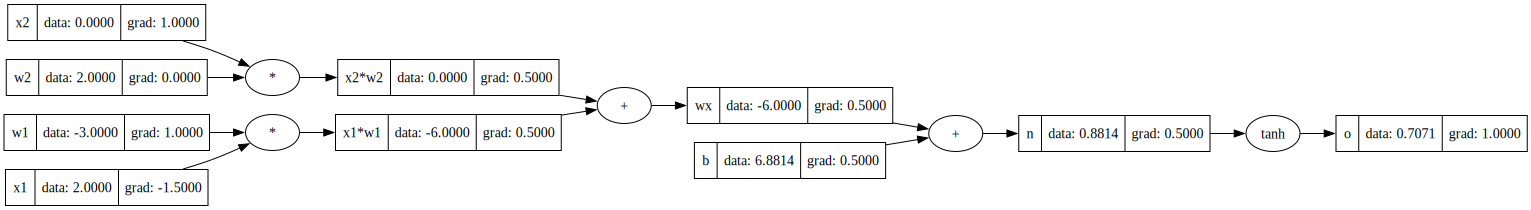

In [58]:
# Input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(2.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Computation
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
wx = x1w1 + x2w2; wx.label = 'wx'
n = wx + b; n.label = 'n'
o = n.tanh()
o.label = 'o'

o.backward()

draw_dot(o)

## Reimplement tanh

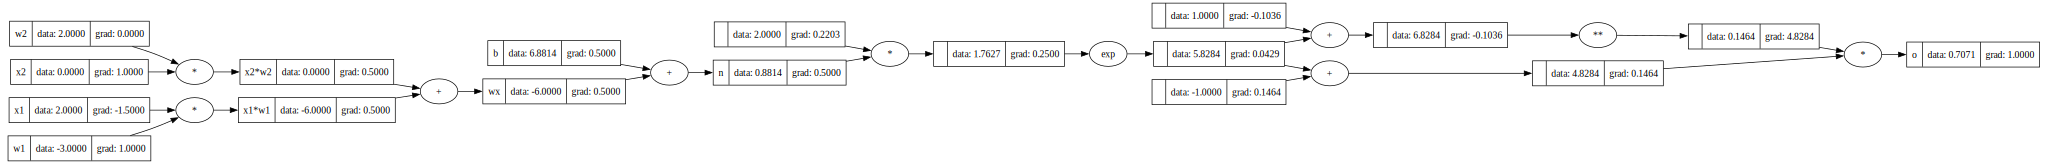

In [61]:
# Input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(2.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Computation
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
wx = x1w1 + x2w2; wx.label = 'wx'
n = wx + b; n.label = 'n'

# We are going to reimplement tanh here.
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()

draw_dot(o)

## Example using PyTorch

In [62]:
import torch

In [67]:
x1 = torch.tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.tensor([2.0]).double();                  w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = n.tanh()
o.backward()

print(o.item())
print('---')
print(x1.grad)
print(w1.grad)
print(x2.grad)
print(w2.grad)
print(b.grad)


0.7071066904050358
---
tensor([-1.5000], dtype=torch.float64)
tensor([1.0000], dtype=torch.float64)
tensor([1.0000], dtype=torch.float64)
tensor([0.], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64)
